In [1]:
import random
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sktime.forecasting.arch import ARCH
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBRegressor

from functions.evaluate_garch import evaluate_garch, evaluate_gjr_garch
from functions.evaluate_xgb import evaluate_xgboost, evaluate_hybrid_xgboost_with_garch
from functions.evaluate_lstm import build_lstm_model, evaluate_lstm, evaluate_hybrid_lstm_with_garch
from functions.metrics import qlike
from functions.dataprep import create_features_and_target_garch_xgb, create_features_and_target_xgb, create_sequences, create_sequences_garch

# 1. data

In [43]:
GARCH_PARAMETERS = {
    'p': 1,
    'q': 1,
    'mean': 'Zero',
    'dist': "Normal",
    'vol': 'GARCH',
    'method': 'analytic',
    'random_state': 42,
    'rescale': False
}

GJRGARCH_PARAMETERS = {
    'p': 1,
    'o': 1,
    'q': 1,
    'mean': 'Zero',
    'dist': "Normal",
    'vol': 'GARCH',
    'method': 'analytic',
    'random_state': 42,
    'rescale': False
}

XGB_PARAMETERS = {
    # 'objective': 'reg:squarederror',
    'objective': 'reg:tweedie',
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 3,
    'random_state': 42,
    'eval_metric': 'rmse'
}

LSTM_PARAMETERS = {
    'seq_length': 5,
    'hidden_size': 50,
    'num_layers': 1,
    'batch_size': 32,
    'epochs': 20,
    'learning_rate': 0.001,
    'random_state': 42
}

REESTIMATE_EVERY = 20

XGB_LAG = 5

In [3]:
TICKER = "BZ=F"
START = "2010-01-01"
END = "2025-06-30"
data = yf.download(TICKER, start=START, end=END, progress=False)
spot = data['Close'][TICKER]
returns = np.log(spot / spot.shift(1)).dropna()
returns.index = pd.PeriodIndex(returns.index, freq='D')
TRAIN_START = START
TRAIN_END = "2023-12-31"
TEST_START = "2024-01-01"
TEST_END = END

train_returns = returns[TRAIN_START:TEST_START]
test_returns = returns[TEST_START:TEST_END]

# Random global for the notebook

seed = 42
# Set seeds for Python libraries
random.seed(seed)
np.random.seed(seed)
# Set seed for TensorFlow
tf.random.set_seed(seed)


C:\Users\Szymon.Stolarski\AppData\Local\Temp\ipykernel_19476\540630726.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=START, end=END, progress=False)


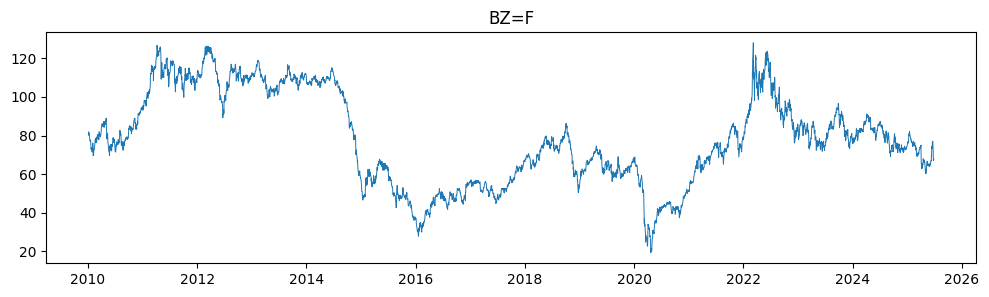

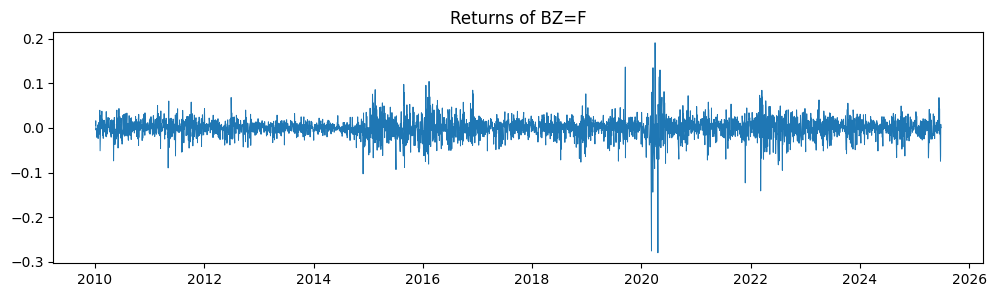

In [4]:
plt.figure(figsize=(12,3))
plt.plot(spot, linewidth=0.7)
plt.title(TICKER)
plt.show()

plt.figure(figsize=(12,3))
plt.plot(returns.index.to_timestamp(), returns.values, label='Daily Returns', linewidth=0.7)
plt.title(f"Returns of {TICKER}")
plt.show()

# 2. Models
## 2.1. GARCH

In [5]:
# Fit ARCH model on returns
# forecaster = ARCH(p=1, q=1, mean='Zero', dist="Normal", vol='GARCH',
#                   method='analytic', random_state=42, rescale=False)
forecaster = ARCH(**GARCH_PARAMETERS)
forecaster.fit(train_returns)
print(forecaster.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   BZ=F   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                8784.99
Distribution:                  Normal   AIC:                          -17564.0
Method:            Maximum Likelihood   BIC:                          -17545.5
                                        No. Observations:                 3488
Date:                Sat, Oct 25 2025   Df Residuals:                     3488
Time:                        14:07:59   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.0662e-05  6.829e-12  1.561e+06      0.000 [1.

In [6]:
conditional_variance_out_of_sample_GARCH = evaluate_garch(
    train_returns, test_returns, GARCH_PARAMETERS, reestimate_every=REESTIMATE_EVERY)

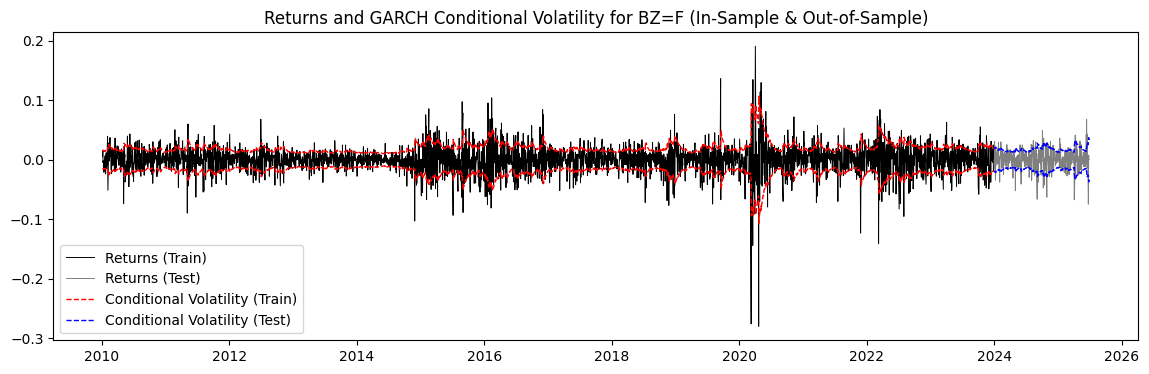

In [7]:
conditional_volatility_in_sample_GARCH = np.sqrt(forecaster.predict_var(fh=train_returns.index))
conditional_variance_in_sample_GARCH = forecaster.predict_var(fh=train_returns.index)
# conditional_variance_out_of_sample_GARCH = forecaster.predict_var(fh=test_returns.index)
conditional_volatility_out_of_sample_GARCH = np.sqrt(conditional_variance_out_of_sample_GARCH)

plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(conditional_volatility_in_sample_GARCH.index.to_timestamp(), conditional_volatility_in_sample_GARCH.values, label='Conditional Volatility (Train)', color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_in_sample_GARCH.index.to_timestamp(), -1 * conditional_volatility_in_sample_GARCH.values, color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample_GARCH.index.to_timestamp(), conditional_volatility_out_of_sample_GARCH.values, label='Conditional Volatility (Test)', color='blue', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample_GARCH.index.to_timestamp(), -1 * conditional_volatility_out_of_sample_GARCH.values, color='blue', linestyle='--', linewidth=1)
plt.title(f"Returns and GARCH Conditional Volatility for {TICKER} (In-Sample & Out-of-Sample)")
plt.legend()
plt.show()

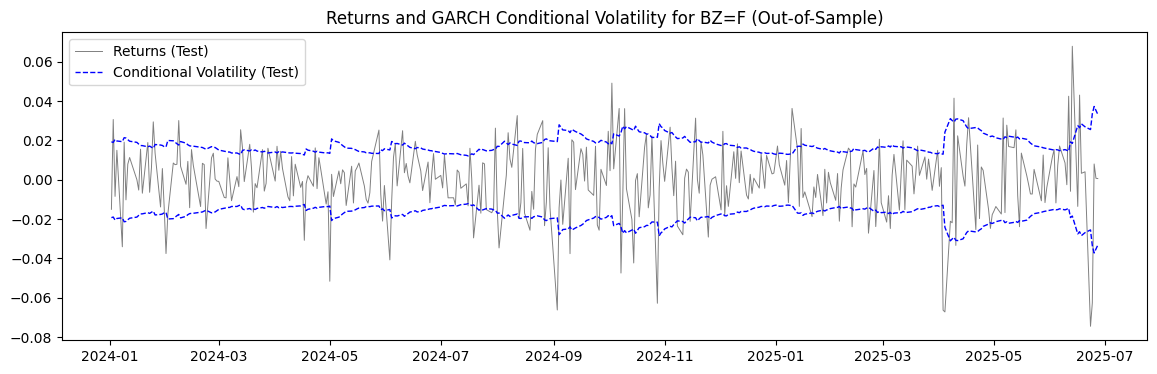

In [8]:
plt.figure(figsize=(14, 4))
#plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
#plt.plot(conditional_volatility_in_sample.index.to_timestamp(), conditional_volatility_in_sample.values, label='Conditional Volatility (Train)', color='red', linestyle='--', linewidth=1)
#plt.plot(conditional_volatility_in_sample.index.to_timestamp(), -1 * conditional_volatility_in_sample.values, color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample_GARCH.index.to_timestamp(), conditional_volatility_out_of_sample_GARCH.values, label='Conditional Volatility (Test)', color='blue', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample_GARCH.index.to_timestamp(), -1 * conditional_volatility_out_of_sample_GARCH.values, color='blue', linestyle='--', linewidth=1)
plt.title(f"Returns and GARCH Conditional Volatility for {TICKER} (Out-of-Sample)")
plt.legend()
plt.show()

In [9]:
# Forecasted volatility (out-of-sample)
forecast_vol = conditional_variance_out_of_sample_GARCH

# Realized volatility: use squared returns as a proxy
realized_vol = test_returns ** 2

# Metrics
mse_garch = mean_squared_error(realized_vol, forecast_vol)
rmse_garch = np.sqrt(mse_garch)
mae_garch = mean_absolute_error(realized_vol, forecast_vol)
qlk_garch = qlike(realized_vol, forecast_vol)
# corr = np.corrcoef(realized_vol, forecast_vol)[0, 1]

print(f"Mean Squared Error (MSE): {mse_garch:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse_garch:.6f}")
print(f"Mean Absolute Error (MAE): {mae_garch:.6f}")
print(f"Q-Like: {qlk_garch:.6f}")
# print(f"Correlation (Realized vs Forecasted Volatility): {corr:.4f}")

Mean Squared Error (MSE): 0.000000
Root Mean Squared Error (RMSE): 0.000680
Mean Absolute Error (MAE): 0.000356
Q-Like: inf


f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## 2.2. GJR-GARCH

In [10]:
# Fit ARCH model on returns
# forecaster = ARCH(p=1, q=1, o=1, mean='Zero', dist="Normal", vol='GARCH', method='analytic', random_state=42, rescale=False)
forecaster = ARCH(**GJRGARCH_PARAMETERS)
forecaster.fit(train_returns)
print(forecaster.summary())

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                   BZ=F   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                8805.47
Distribution:                  Normal   AIC:                          -17602.9
Method:            Maximum Likelihood   BIC:                          -17578.3
                                        No. Observations:                 3488
Date:                Sat, Oct 25 2025   Df Residuals:                     3488
Time:                        14:08:04   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.0556e-05  8.196e-12  1.288e+06      0.000 [1.

In [11]:
conditional_variance_out_of_sample_GJRGARCH = evaluate_gjr_garch(
    train_returns, test_returns, GJRGARCH_PARAMETERS, reestimate_every=REESTIMATE_EVERY
)

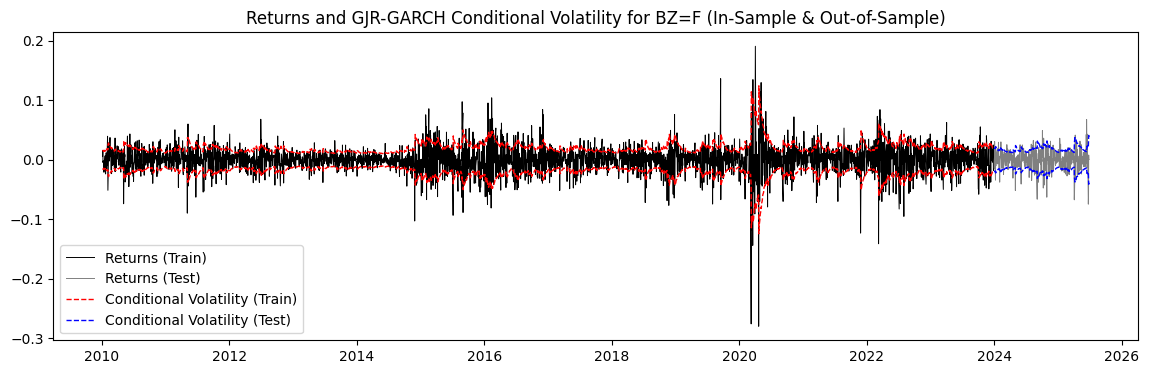

In [12]:
conditional_variance_in_sample_GJRGARCH = forecaster.predict_var(fh=train_returns.index)
conditional_volatility_in_sample_GJRGARCH = np.sqrt(forecaster.predict_var(fh=train_returns.index))
# conditional_variance_out_of_sample_GJRGARCH = forecaster.predict_var(fh=test_returns.index)
conditional_volatility_out_of_sample_GJRGARCH = np.sqrt(conditional_variance_out_of_sample_GJRGARCH)

plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(conditional_volatility_in_sample_GJRGARCH.index.to_timestamp(), conditional_volatility_in_sample_GJRGARCH.values, label='Conditional Volatility (Train)', color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_in_sample_GJRGARCH.index.to_timestamp(), -1 * conditional_volatility_in_sample_GJRGARCH.values, color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample_GJRGARCH.index.to_timestamp(), conditional_volatility_out_of_sample_GJRGARCH.values, label='Conditional Volatility (Test)', color='blue', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample_GJRGARCH.index.to_timestamp(), -1 * conditional_volatility_out_of_sample_GJRGARCH.values, color='blue', linestyle='--', linewidth=1)
plt.title(f"Returns and GJR-GARCH Conditional Volatility for {TICKER} (In-Sample & Out-of-Sample)")
plt.legend()
plt.show()

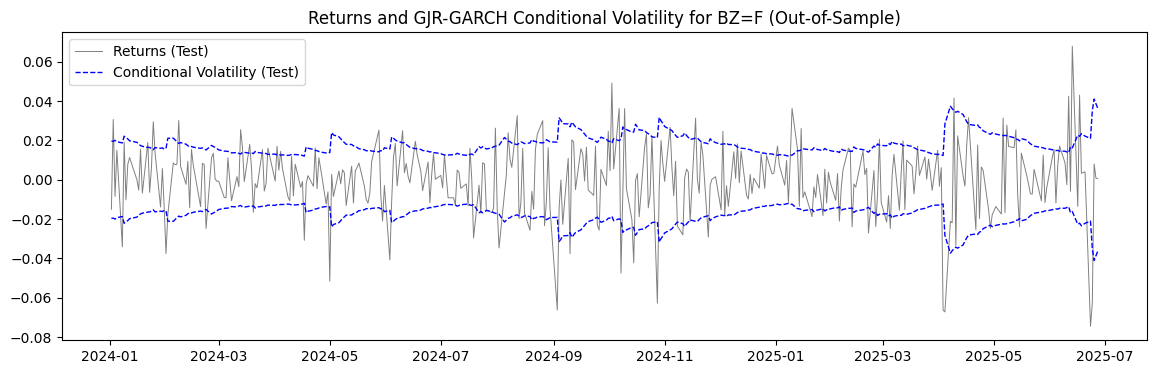

In [13]:
plt.figure(figsize=(14, 4))
#plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
#plt.plot(conditional_volatility_in_sample.index.to_timestamp(), conditional_volatility_in_sample.values, label='Conditional Volatility (Train)', color='red', linestyle='--', linewidth=1)
#plt.plot(conditional_volatility_in_sample.index.to_timestamp(), -1 * conditional_volatility_in_sample.values, color='red', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample_GJRGARCH.index.to_timestamp(), conditional_volatility_out_of_sample_GJRGARCH.values, label='Conditional Volatility (Test)', color='blue', linestyle='--', linewidth=1)
plt.plot(conditional_volatility_out_of_sample_GJRGARCH.index.to_timestamp(), -1 * conditional_volatility_out_of_sample_GJRGARCH.values, color='blue', linestyle='--', linewidth=1)
plt.title(f"Returns and GJR-GARCH Conditional Volatility for {TICKER} (Out-of-Sample)")
plt.legend()
plt.show()

In [14]:
# Forecasted volatility (out-of-sample)
forecast_vol = conditional_variance_out_of_sample_GJRGARCH

# Realized volatility: use squared returns as a proxy
realized_vol = test_returns ** 2

# Metrics
mse_gjrgarch = mean_squared_error(realized_vol, forecast_vol)
rmse_gjrgarch = np.sqrt(mse_gjrgarch)
mae_gjrgarch = mean_absolute_error(realized_vol, forecast_vol)
qlk_gjrgarch = qlike(realized_vol, forecast_vol)
# corr = np.corrcoef(realized_vol, forecast_vol)[0, 1]

print(f"Mean Squared Error (MSE): {mse_gjrgarch:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse_gjrgarch:.6f}")
print(f"Mean Absolute Error (MAE): {mae_gjrgarch:.6f}")
print(f"Q-Like: {qlk_gjrgarch:.6f}")
# print(f"Correlation (Realized vs Forecasted Volatility): {corr:.4f}")

Mean Squared Error (MSE): 0.000000
Root Mean Squared Error (RMSE): 0.000697
Mean Absolute Error (MAE): 0.000370
Q-Like: inf


f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## 2.3. XGBoost
### 2.3.1. With only lagged returns as input

In [44]:
conditional_variance_out_of_sample_XGB = evaluate_xgboost(
    train_returns, test_returns, XGB_PARAMETERS, lags=XGB_LAG, reestimate_every=REESTIMATE_EVERY)

XGB_model = XGBRegressor(**XGB_PARAMETERS)

X_train, y_train = create_features_and_target_xgb(train_returns, lags=XGB_LAG)
XGB_model.fit(X_train, y_train)
# predict returns a numpy array — convert to pd.Series and align index with X_train
conditional_variance_in_sample_XGB = pd.Series(
    XGB_model.predict(X_train),
    index=X_train.index, name='predicted_variance')

In [45]:
# Forecasted volatility (out-of-sample)
forecast_vol = conditional_variance_out_of_sample_XGB
# Realized volatility 
realized_vol =test_returns ** 2

# Evaluate
mse_xgb = mean_squared_error(realized_vol, forecast_vol)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(realized_vol, forecast_vol)
qlk_xgb = qlike(realized_vol, forecast_vol)
#corr_xgb = np.corrcoef(realized_vol, forecast_vol)[0, 1]


print(f"XGBoost - MSE: {mse_xgb:.6f}")
print(f"XGBoost - RMSE: {rmse_xgb:.6f}")
print(f"XGBoost - MAE: {mae_xgb:.6f}")
print(f"XGBoost - Q-Like: {qlk_xgb:.6f}")
#print(f"XGBoost - Correlation: {corr_xgb:.4f}")

XGBoost - MSE: 0.000001
XGBoost - RMSE: 0.000740
XGBoost - MAE: 0.000384
XGBoost - Q-Like: inf


f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


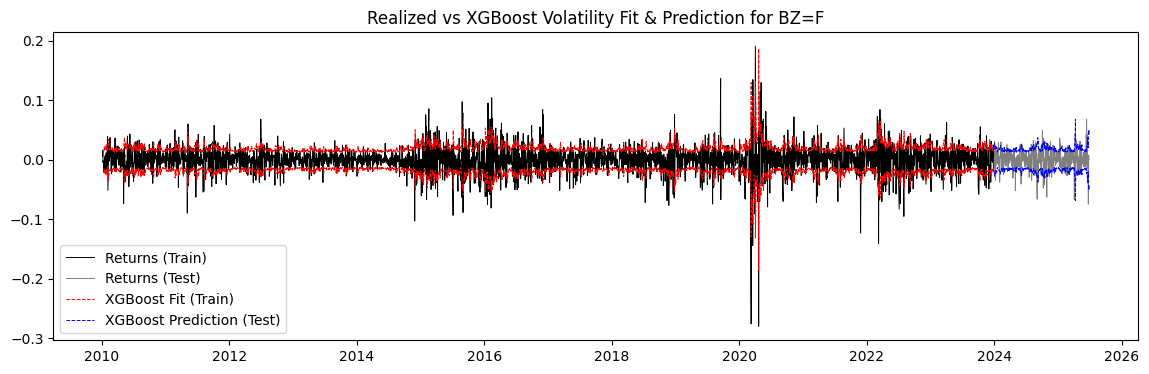

In [46]:
plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
# plt.plot(y_train_lagged.index.to_timestamp(), y_train_lagged.values, label='Realized Volatility (Train)', color='black', linewidth=0.7)
# plt.plot(y_test_lagged.index.to_timestamp(), y_test_lagged.values, label='Realized Volatility (Test)', color='gray', linewidth=0.7)
plt.plot(conditional_variance_in_sample_XGB.index.to_timestamp(), np.sqrt(conditional_variance_in_sample_XGB), label='XGBoost Fit (Train)', color='red', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_XGB.index.to_timestamp(), np.sqrt(conditional_variance_out_of_sample_XGB), label='XGBoost Prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_in_sample_XGB.index.to_timestamp(), -np.sqrt(conditional_variance_in_sample_XGB), color='red', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_XGB.index.to_timestamp(), -np.sqrt(conditional_variance_out_of_sample_XGB), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"Realized vs XGBoost Volatility Fit & Prediction for {TICKER}")
plt.legend()
plt.show()

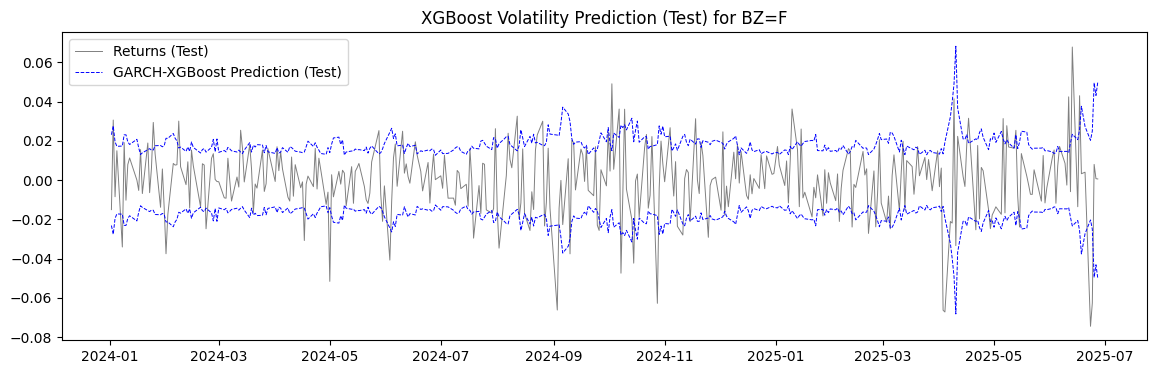

In [47]:
plt.figure(figsize=(14, 4))
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_XGB.index.to_timestamp(), np.sqrt(conditional_variance_out_of_sample_XGB), label='GARCH-XGBoost Prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_XGB.index.to_timestamp(), -np.sqrt(conditional_variance_out_of_sample_XGB), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"XGBoost Volatility Prediction (Test) for {TICKER}")
plt.legend()
plt.show()

## 2.4. Hybrid: GARCH-XGBoost/GJR-GARCH - XGBoost
1. Take outputs from GARCH (predicted volatility) both from insample (train) and out of sample (predict())
2. Fit the XGBoost model both on the lagged returns and outputs from GARCH
3. Predict forward recursively

### 2.4.1. GARCH-XGBoost

In [48]:
conditional_variance_out_of_sample_GARCH_XGB = evaluate_hybrid_xgboost_with_garch(
    train_returns, test_returns, GARCH_PARAMETERS, XGB_PARAMETERS, lags=XGB_LAG, reestimate_every=REESTIMATE_EVERY)
XGB_model = XGBRegressor(**XGB_PARAMETERS)
X_train, y_train = create_features_and_target_garch_xgb(
    train_returns, conditional_variance_in_sample_GARCH, lags=XGB_LAG)
XGB_model.fit(X_train, y_train)
# predict returns a numpy array — convert to pd.Series and align index with X_train
conditional_variance_in_sample_GARCH_XGB = pd.Series(
    XGB_model.predict(X_train),
    index=X_train.index, name='predicted_variance')

In [49]:
# Forecasted volatility (out-of-sample)
forecast_vol = conditional_variance_out_of_sample_GARCH_XGB
# Realized volatility
realized_vol = test_returns ** 2

# Evaluate
mse_xgb_garch = mean_squared_error(realized_vol, forecast_vol)
rmse_xgb_garch = np.sqrt(mse_xgb_garch)
mae_xgb_garch = mean_absolute_error(realized_vol, forecast_vol)
qlk_xgb_garch = qlike(realized_vol, forecast_vol)
# corr_xgb = np.corrcoef(realized_vol, forecast_vol)[0, 1]


print(f"GARCH-XGBoost - MSE: {mse_xgb_garch:.6f}")
print(f"GARCH-XGBoost - RMSE: {rmse_xgb_garch:.6f}")
print(f"GARCH-XGBoost - MAE: {mae_xgb_garch:.6f}")
print(f"GARCH-XGBoost - Q-Like: {qlk_xgb_garch:.6f}")
# print(f"GARCH-XGBoost - Correlation: {corr_xgb:.4f}")

GARCH-XGBoost - MSE: 0.000000
GARCH-XGBoost - RMSE: 0.000694
GARCH-XGBoost - MAE: 0.000354
GARCH-XGBoost - Q-Like: inf


f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


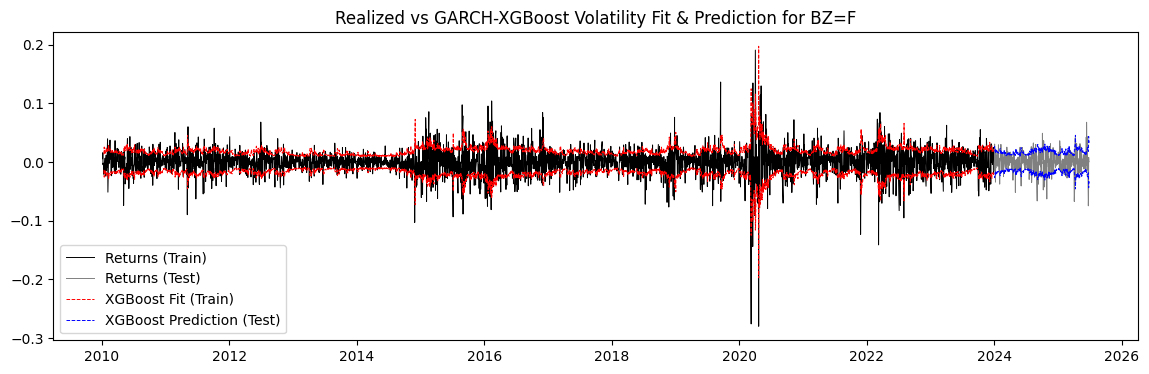

In [50]:
plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
# plt.plot(y_train_lagged.index.to_timestamp(), y_train_lagged.values, label='Realized Volatility (Train)', color='black', linewidth=0.7)
# plt.plot(y_test_lagged.index.to_timestamp(), y_test_lagged.values, label='Realized Volatility (Test)', color='gray', linewidth=0.7)
plt.plot(conditional_variance_in_sample_GARCH_XGB.index.to_timestamp(), np.sqrt(conditional_variance_in_sample_GARCH_XGB), label='XGBoost Fit (Train)', color='red', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_GARCH_XGB.index.to_timestamp(), np.sqrt(conditional_variance_out_of_sample_GARCH_XGB).bfill(), label='XGBoost Prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_in_sample_GARCH_XGB.index.to_timestamp(), -np.sqrt(conditional_variance_in_sample_GARCH_XGB), color='red', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_GARCH_XGB.index.to_timestamp(), -np.sqrt(conditional_variance_out_of_sample_GARCH_XGB).bfill(), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"Realized vs GARCH-XGBoost Volatility Fit & Prediction for {TICKER}")
plt.legend()
plt.show()

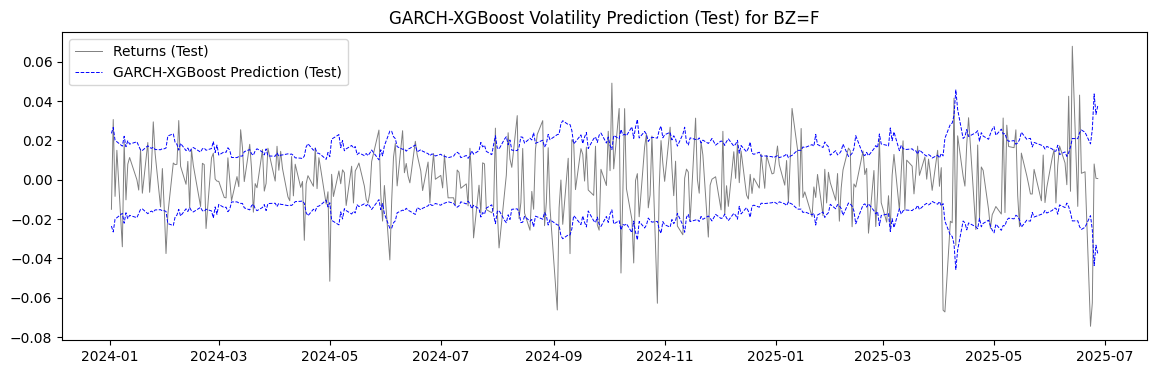

In [51]:
plt.figure(figsize=(14, 4))
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), np.sqrt(conditional_variance_out_of_sample_GARCH_XGB).bfill(), label='GARCH-XGBoost Prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), -np.sqrt(conditional_variance_out_of_sample_GARCH_XGB).bfill(), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"GARCH-XGBoost Volatility Prediction (Test) for {TICKER}")
plt.legend()
plt.show()

### 2.4.2. GJR-GARCH - XGBoost

In [52]:
conditional_variance_out_of_sample_GJRGARCH_XGB = evaluate_hybrid_xgboost_with_garch(
    train_returns, test_returns, GJRGARCH_PARAMETERS, XGB_PARAMETERS, lags=XGB_LAG, reestimate_every=REESTIMATE_EVERY)

XGB_model = XGBRegressor(**XGB_PARAMETERS)
X_train, y_train = create_features_and_target_garch_xgb(train_returns, conditional_variance_in_sample_GJRGARCH, lags=XGB_LAG)
XGB_model.fit(X_train, y_train)
# predict returns a numpy array — convert to pd.Series and align index with X_train
conditional_variance_in_sample_GJRGARCH_XGB = pd.Series(
    XGB_model.predict(X_train),
    index=X_train.index, name='predicted_variance')

In [53]:
# Forecasted volatility (out-of-sample)
forecast_vol = conditional_variance_out_of_sample_GJRGARCH_XGB
# Realized volatility
realized_vol = test_returns ** 2

# Evaluate
mse_xgb_gjrgarch = mean_squared_error(realized_vol, forecast_vol)
rmse_xgb_gjrgarch = np.sqrt(mse_xgb_gjrgarch)
mae_xgb_gjrgarch = mean_absolute_error(realized_vol, forecast_vol)
qlk_xgb_gjrgarch = qlike(realized_vol, forecast_vol)
# corr_xgb = np.corrcoef(realized_vol, forecast_vol)[0, 1]


print(f"GJRGARCH-XGBoost - MSE: {mse_xgb_gjrgarch:.6f}")
print(f"GJRGARCH-XGBoost - RMSE: {rmse_xgb_gjrgarch:.6f}")
print(f"GJRGARCH-XGBoost - MAE: {mae_xgb_gjrgarch:.6f}")
print(f"GJRGARCH-XGBoost - Q-Like: {qlk_xgb_gjrgarch:.6f}")
# print(f"GJRGARCH-XGBoost - Correlation: {corr_xgb:.4f}")

GJRGARCH-XGBoost - MSE: 0.000000
GJRGARCH-XGBoost - RMSE: 0.000694
GJRGARCH-XGBoost - MAE: 0.000356
GJRGARCH-XGBoost - Q-Like: inf


f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


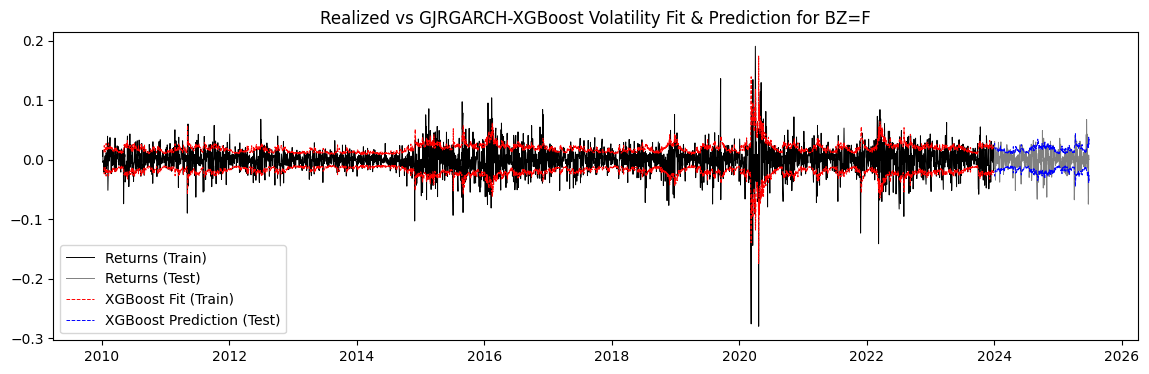

In [54]:
plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
# plt.plot(y_train_lagged.index.to_timestamp(), y_train_lagged.values, label='Realized Volatility (Train)', color='black', linewidth=0.7)
# plt.plot(y_test_lagged.index.to_timestamp(), y_test_lagged.values, label='Realized Volatility (Test)', color='gray', linewidth=0.7)
plt.plot(conditional_variance_in_sample_GJRGARCH_XGB.index.to_timestamp(), np.sqrt(conditional_variance_in_sample_GJRGARCH_XGB), label='XGBoost Fit (Train)', color='red', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_GJRGARCH_XGB.index.to_timestamp(), np.sqrt(conditional_variance_out_of_sample_GJRGARCH_XGB).bfill(), label='XGBoost Prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_in_sample_GJRGARCH_XGB.index.to_timestamp(), -np.sqrt(conditional_variance_in_sample_GJRGARCH_XGB), color='red', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_GJRGARCH_XGB.index.to_timestamp(), -np.sqrt(conditional_variance_out_of_sample_GJRGARCH_XGB).bfill(), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"Realized vs GJRGARCH-XGBoost Volatility Fit & Prediction for {TICKER}")
plt.legend()
plt.show()

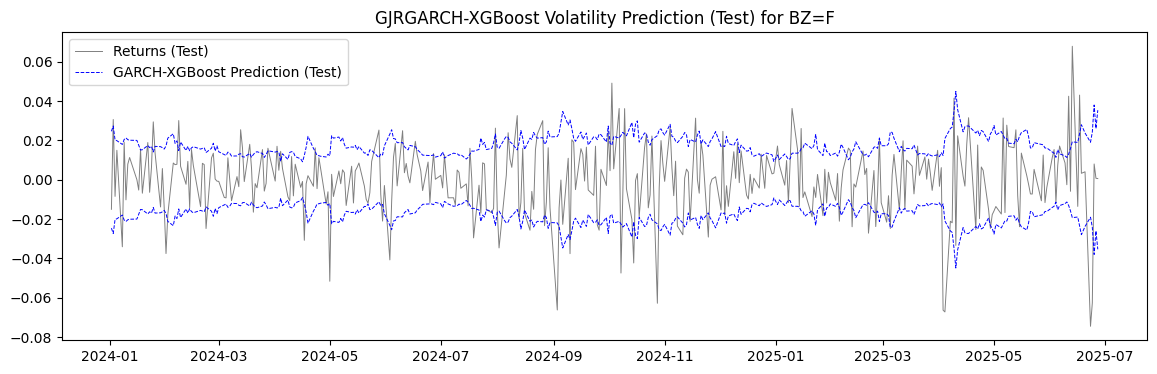

In [55]:
plt.figure(figsize=(14, 4))
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_GJRGARCH_XGB.index.to_timestamp(), np.sqrt(conditional_variance_out_of_sample_GJRGARCH_XGB).bfill(), label='GARCH-XGBoost Prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_GJRGARCH_XGB.index.to_timestamp(), -np.sqrt(conditional_variance_out_of_sample_GJRGARCH_XGB).bfill(), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"GJRGARCH-XGBoost Volatility Prediction (Test) for {TICKER}")
plt.legend()
plt.show()

## 2.5. LSTM

In [27]:
model = build_lstm_model(
    seq_length=LSTM_PARAMETERS['seq_length'], hidden_size=LSTM_PARAMETERS['hidden_size'], num_layers=1)
X_train, y_train = create_sequences(train_returns, seq_length=LSTM_PARAMETERS['seq_length'])
model.fit(X_train, y_train, epochs = LSTM_PARAMETERS['epochs'], batch_size = LSTM_PARAMETERS['batch_size'])

conditional_variance_in_sample_LSTM = pd.Series(
    model.predict(X_train).flatten(),
    index=train_returns.index[LSTM_PARAMETERS['seq_length']:], name='predicted_variance')


conditional_variance_out_of_sample_LSTM = evaluate_lstm(
    train_returns, test_returns, LSTM_PARAMETERS, reestimate_every=REESTIMATE_EVERY)

f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 1.1367e-05
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.6306e-06
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.5348e-06
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.5316e-06
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.5653e-06
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.6349e-06
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.6573e-06
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.5714e-06
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.5146e-06
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.4722e-06
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.4366e-06
Epoch 12/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.4070e-06
Epoch 13/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.3825e-06
Epoch 14/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.3620e-

f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarni

f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


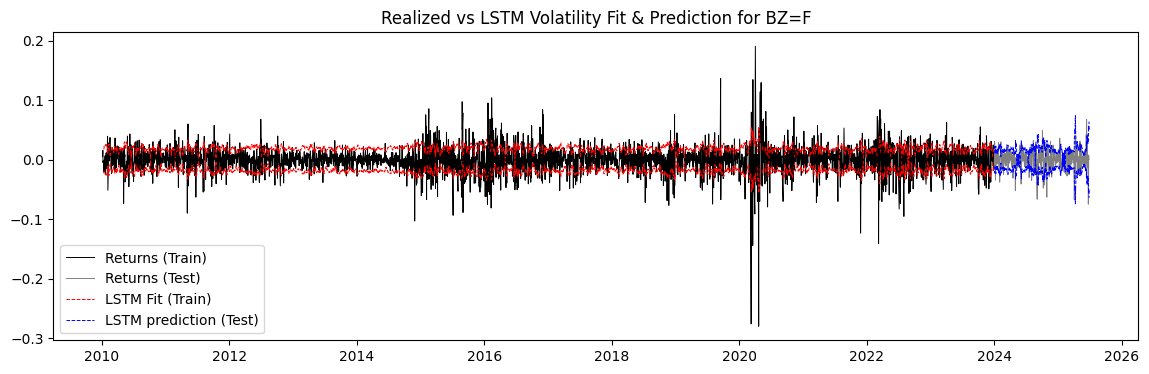

In [28]:
plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(conditional_variance_in_sample_LSTM.index, np.sqrt(conditional_variance_in_sample_LSTM), label='LSTM Fit (Train)', color='red', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_LSTM.index, np.sqrt(conditional_variance_out_of_sample_LSTM), label='LSTM prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_in_sample_LSTM.index, -np.sqrt(conditional_variance_in_sample_LSTM), color='red', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_LSTM.index, -np.sqrt(conditional_variance_out_of_sample_LSTM), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"Realized vs LSTM Volatility Fit & Prediction for {TICKER}")
plt.legend()
plt.show()

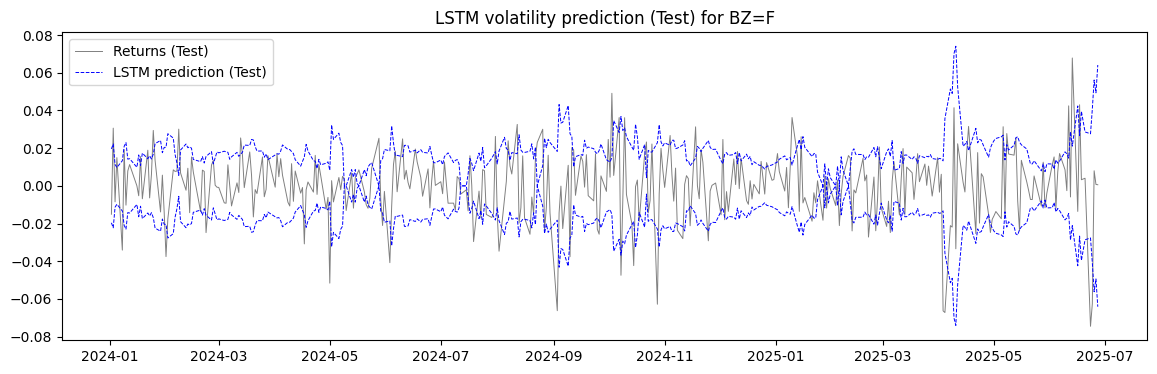

In [29]:
plt.figure(figsize=(14, 4))
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_LSTM.index, np.sqrt(conditional_variance_out_of_sample_LSTM), label='LSTM prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_LSTM.index, -np.sqrt(conditional_variance_out_of_sample_LSTM), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"LSTM volatility prediction (Test) for {TICKER}")
plt.legend()
plt.show()

In [30]:
# Forecasted volatility (out-of-sample)
forecast_vol = conditional_variance_out_of_sample_LSTM
# Realized volatility
realized_vol = test_returns ** 2

# Evaluate
mse_lstm = mean_squared_error(realized_vol, forecast_vol)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(realized_vol, forecast_vol)
qlk_lstm = qlike(realized_vol, forecast_vol)
# corr_xgb = np.corrcoef(realized_vol, forecast_vol)[0, 1]


print(f"LSTM - MSE: {mse_lstm:.6f}")
print(f"LSTM - RMSE: {rmse_lstm:.6f}")
print(f"LSTM - MAE: {mae_lstm:.6f}")
print(f"LSTM - Q-Like: {qlk_lstm:.6f}")
# print(f"LSTM - Correlation: {corr_xgb:.4f}")


LSTM - MSE: 0.000001
LSTM - RMSE: 0.000818
LSTM - MAE: 0.000430
LSTM - Q-Like: inf


f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## 2.6. Hybrid: GARCH-LSTM
### 2.6.1. GARCH-LSTM

In [31]:
model = build_lstm_model(seq_length=LSTM_PARAMETERS['seq_length'],
                         hidden_size=LSTM_PARAMETERS['hidden_size'],
                         num_layers=LSTM_PARAMETERS['num_layers'],
                         input_features=2)
X_train, y_train = create_sequences_garch(
    train_returns, conditional_variance_in_sample_GARCH, seq_length=LSTM_PARAMETERS['seq_length'])
model.fit(X_train, y_train, epochs = LSTM_PARAMETERS['epochs'], batch_size = LSTM_PARAMETERS['batch_size'])

conditional_variance_in_sample_GARCH_LSTM = pd.Series(
    model.predict(X_train).flatten(),
    index=train_returns.index[LSTM_PARAMETERS['seq_length']:], name='predicted_variance')

conditional_variance_out_of_sample_GARCH_LSTM = evaluate_hybrid_lstm_with_garch(
    train_returns, test_returns, GARCH_PARAMETERS, LSTM_PARAMETERS, reestimate_every=REESTIMATE_EVERY)

Epoch 1/20


f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.2061e-05
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.5291e-06
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.3292e-06
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.2479e-06
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.1996e-06
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.1713e-06
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.1609e-06
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.1687e-06
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.1918e-06
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.2386e-06
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2750e-06
Epoch 12/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.2261e-06
Epoch 13/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.1787e-06
Epoch 14/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.1463e-06
Epoch 15/20


f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarni

f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


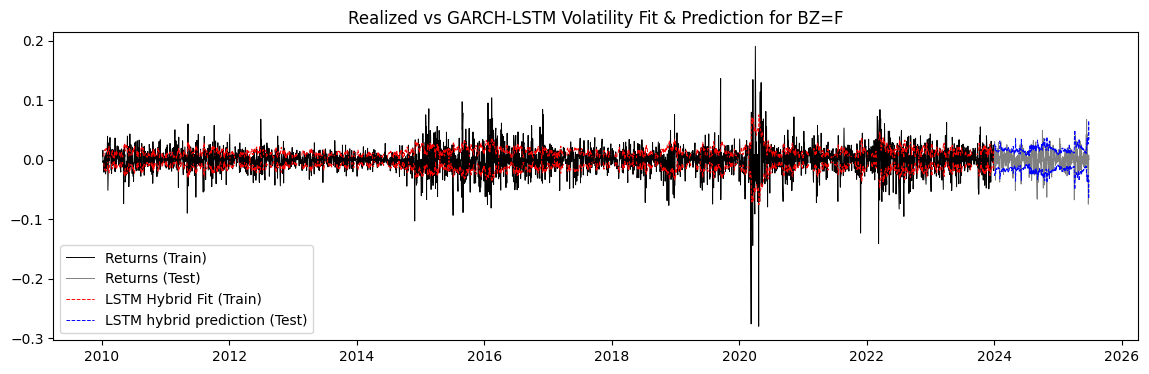

In [32]:
plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(conditional_variance_in_sample_GARCH_LSTM.index, np.sqrt(conditional_variance_in_sample_GARCH_LSTM), label='LSTM Hybrid Fit (Train)', color='red', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_GARCH_LSTM.index, np.sqrt(conditional_variance_out_of_sample_GARCH_LSTM), label='LSTM hybrid prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_in_sample_GARCH_LSTM.index, -np.sqrt(conditional_variance_in_sample_GARCH_LSTM), color='red', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_GARCH_LSTM.index, -np.sqrt(conditional_variance_out_of_sample_GARCH_LSTM), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"Realized vs GARCH-LSTM Volatility Fit & Prediction for {TICKER}")
plt.legend()
plt.show()

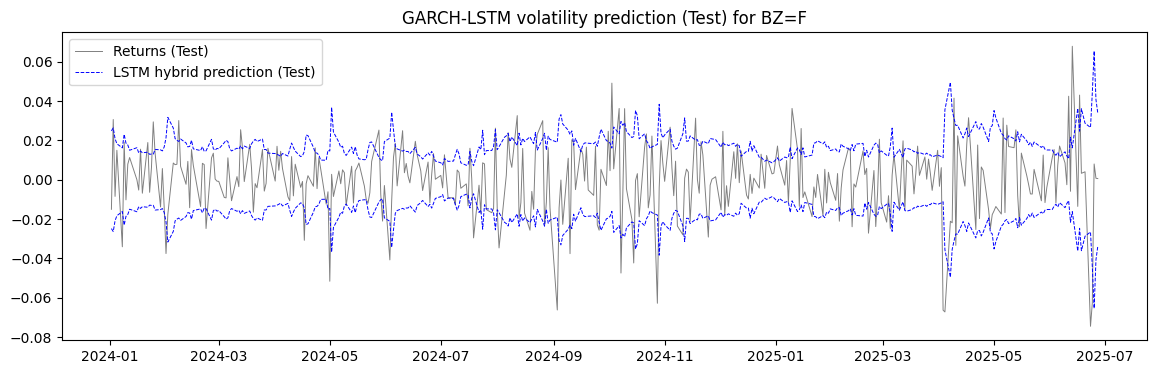

In [33]:
plt.figure(figsize=(14, 4))
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_GARCH_LSTM.index, np.sqrt(conditional_variance_out_of_sample_GARCH_LSTM), label='LSTM hybrid prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_GARCH_LSTM.index, -np.sqrt(conditional_variance_out_of_sample_GARCH_LSTM), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"GARCH-LSTM volatility prediction (Test) for {TICKER}")
plt.legend()
plt.show()

In [34]:
# Forecasted volatility (out-of-sample)
forecast_vol = conditional_variance_out_of_sample_GARCH_LSTM
realized_vol = test_returns ** 2
# Evaluate
mse_lstm_garch = mean_squared_error(realized_vol, forecast_vol)
rmse_lstm_garch = np.sqrt(mse_lstm_garch)
mae_lstm_garch = mean_absolute_error(realized_vol, forecast_vol)
qlk_lstm_garch = qlike(realized_vol, forecast_vol)
# corr_xgb = np.corrcoef(realized_vol, forecast_vol)[0, 1]


print(f"LSTM hybrid garch - MSE: {mse_lstm_garch:.6f}")
print(f"LSTM hybrid garch - RMSE: {rmse_lstm_garch:.6f}")
print(f"LSTM hybrid garch - MAE: {mae_lstm_garch:.6f}")
print(f"LSTM hybrid garch - Q-Like: {qlk_lstm_garch:.6f}")
# print(f"LSTM hybrid - Correlation: {corr_xgb:.4f}")

LSTM hybrid garch - MSE: 0.000001
LSTM hybrid garch - RMSE: 0.000729
LSTM hybrid garch - MAE: 0.000381
LSTM hybrid garch - Q-Like: inf


f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### 2.6.2. GJRGARCH-LSTM

In [35]:
model = build_lstm_model(seq_length=LSTM_PARAMETERS['seq_length'],
                         hidden_size=LSTM_PARAMETERS['hidden_size'],
                         num_layers=LSTM_PARAMETERS['num_layers'],
                         input_features=2)
X_train, y_train = create_sequences_garch(train_returns, conditional_variance_in_sample_GJRGARCH,
                                          seq_length=LSTM_PARAMETERS['seq_length'])
model.fit(X_train, y_train, epochs=LSTM_PARAMETERS['epochs'], batch_size = LSTM_PARAMETERS['batch_size'])

conditional_variance_in_sample_GJRGARCH_LSTM = pd.Series(
    model.predict(X_train).flatten(),
    index=train_returns.index[LSTM_PARAMETERS['seq_length']:], name='predicted_variance')

conditional_variance_out_of_sample_GJRGARCH_LSTM = evaluate_hybrid_lstm_with_garch(
    train_returns, test_returns, GJRGARCH_PARAMETERS, LSTM_PARAMETERS, reestimate_every=REESTIMATE_EVERY)

f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1.1084e-05
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.5169e-06
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.3211e-06
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.2490e-06
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.2210e-06
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.2198e-06
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.2422e-06
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.2852e-06
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.2849e-06
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.2307e-06
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.1889e-06
Epoch 12/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.1579e-06
Epoch 13/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.1320e-06
Epoch 14/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.1097e-06
E

f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarni

f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


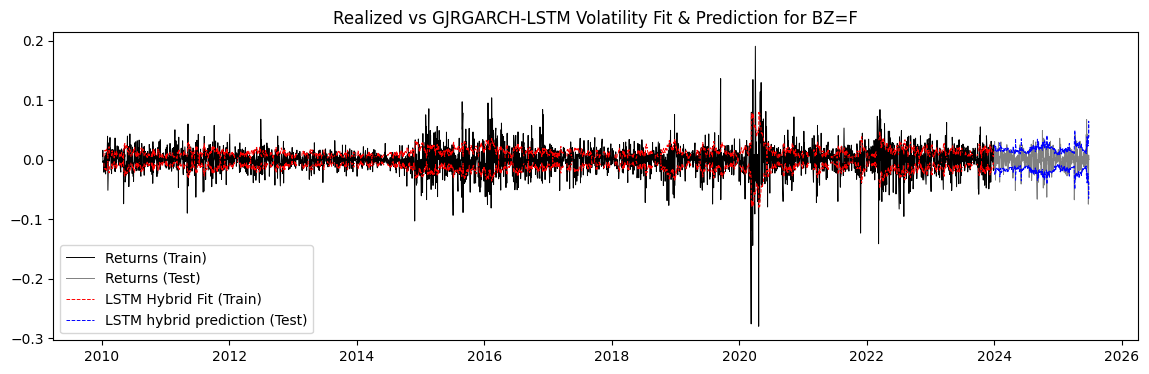

In [36]:
plt.figure(figsize=(14, 4))
plt.plot(train_returns.index.to_timestamp(), train_returns.values, label='Returns (Train)', color='black', linewidth=0.7)
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(conditional_variance_in_sample_GJRGARCH_LSTM.index, np.sqrt(conditional_variance_in_sample_GJRGARCH_LSTM), label='LSTM Hybrid Fit (Train)', color='red', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_GJRGARCH_LSTM.index, np.sqrt(conditional_variance_out_of_sample_GJRGARCH_LSTM), label='LSTM hybrid prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_in_sample_GJRGARCH_LSTM.index, -np.sqrt(conditional_variance_in_sample_GJRGARCH_LSTM), color='red', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_GJRGARCH_LSTM.index, -np.sqrt(conditional_variance_out_of_sample_GJRGARCH_LSTM), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"Realized vs GJRGARCH-LSTM Volatility Fit & Prediction for {TICKER}")
plt.legend()
plt.show()

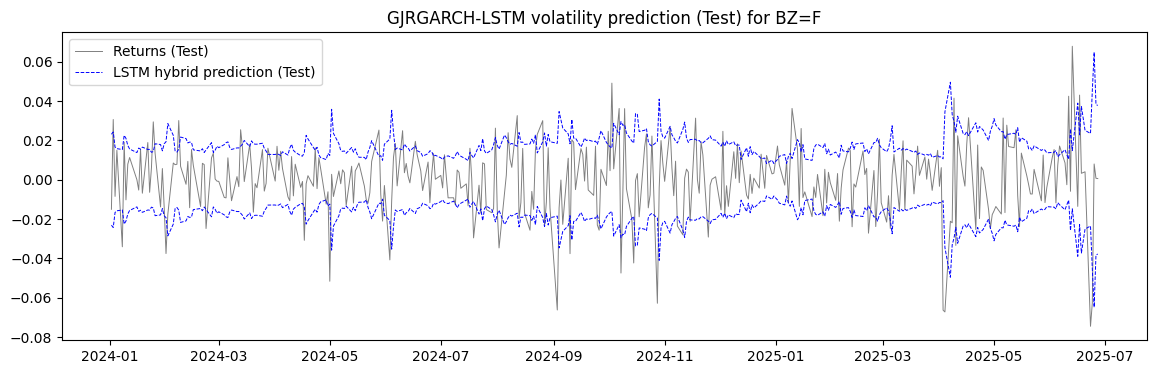

In [37]:
plt.figure(figsize=(14, 4))
plt.plot(test_returns.index.to_timestamp(), test_returns.values, label='Returns (Test)', color='gray', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_GJRGARCH_LSTM.index, np.sqrt(conditional_variance_out_of_sample_GJRGARCH_LSTM), label='LSTM hybrid prediction (Test)', color='blue', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_GJRGARCH_LSTM.index, -np.sqrt(conditional_variance_out_of_sample_GJRGARCH_LSTM), color='blue', linestyle='--', linewidth=0.7)
plt.title(f"GJRGARCH-LSTM volatility prediction (Test) for {TICKER}")
plt.legend()
plt.show()

In [38]:
# Forecasted volatility (out-of-sample)
forecast_vol = conditional_variance_out_of_sample_GARCH_LSTM
realized_vol = test_returns ** 2
# Evaluate
mse_lstm_gjrgarch = mean_squared_error(realized_vol, forecast_vol)
rmse_lstm_gjrgarch = np.sqrt(mse_lstm_gjrgarch)
mae_lstm_gjrgarch = mean_absolute_error(realized_vol, forecast_vol)
qlk_lstm_gjrgarch = qlike(realized_vol, forecast_vol)
# corr_xgb = np.corrcoef(realized_vol, forecast_vol)[0, 1]


print(f"LSTM hybrid garch - MSE: {mse_lstm_gjrgarch:.6f}")
print(f"LSTM hybrid garch - RMSE: {rmse_lstm_garch:.6f}")
print(f"LSTM hybrid garch - MAE: {mae_lstm_gjrgarch:.6f}")
print(f"LSTM hybrid garch - Q-Like: {qlk_lstm_gjrgarch:.6f}")
# print(f"LSTM hybrid - Correlation: {corr_xgb:.4f}")

LSTM hybrid garch - MSE: 0.000001
LSTM hybrid garch - RMSE: 0.000729
LSTM hybrid garch - MAE: 0.000381
LSTM hybrid garch - Q-Like: inf


f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# 3. Summary

In [56]:
from datetime import datetime
timestamp_now = datetime.now().strftime("%Y-%m-%d %H:%M")

# Combine all relevant series into a single DataFrame for analysis
df_all = pd.DataFrame({
    'train_returns': train_returns,
    'test_returns': test_returns,
    'GARCH_in_sample': conditional_variance_in_sample_GARCH,
    'GARCH_out_of_sample': conditional_variance_out_of_sample_GARCH,
    'GJRGARCH_in_sample': conditional_variance_in_sample_GJRGARCH,
    'GJRGARCH_out_of_sample': conditional_variance_out_of_sample_GJRGARCH,
    'XGB_in_sample': conditional_variance_in_sample_XGB,
    'XGB_out_of_sample': conditional_variance_out_of_sample_XGB,
    'GARCH_XGB_in_sample': conditional_variance_in_sample_GARCH_XGB,
    'GARCH_XGB_out_of_sample': conditional_variance_out_of_sample_GARCH_XGB,
    'GJRGARCH_XGB_in_sample': conditional_variance_in_sample_GJRGARCH_XGB,
    'GJRGARCH_XGB_out_of_sample': conditional_variance_out_of_sample_GJRGARCH_XGB,
    'LSTM_in_sample': conditional_variance_in_sample_LSTM,
    'LSTM_out_of_sample': conditional_variance_out_of_sample_LSTM,
    'GARCH_LSTM_in_sample': conditional_variance_in_sample_GARCH_LSTM,
    'GARCH_LSTM_out_of_sample': conditional_variance_out_of_sample_GARCH_LSTM,
    'GJRGARCH_LSTM_in_sample': conditional_variance_in_sample_GJRGARCH_LSTM,
    'GJRGARCH_LSTM_out_of_sample': conditional_variance_out_of_sample_GJRGARCH_LSTM
})

df_all.to_excel(f"volatility_models_comparison_{timestamp_now}.xlsx")

In [59]:
metrics_df = pd.DataFrame({
    'Model': [
        'GARCH', 'GJRGARCH', 'XGBoost', 'GARCH-XGBoost', 'GJRGARCH-XGBoost',
        'LSTM', 'GARCH-LSTM', 'GJRGARCH-LSTM'
    ],
    'MSE': [
        mse_garch, mse_gjrgarch, mse_xgb, mse_xgb_garch, mse_xgb_gjrgarch,
        mse_lstm, mse_lstm_garch, mse_lstm_gjrgarch
    ],
    'RMSE': [
        rmse_garch, rmse_gjrgarch, rmse_xgb, rmse_xgb_garch, rmse_xgb_gjrgarch,
        rmse_lstm, rmse_lstm_garch, rmse_lstm_gjrgarch
    ],
    'MAE': [
        mae_garch, mae_gjrgarch, mae_xgb, mae_xgb_garch, mae_xgb_gjrgarch,
        mae_lstm, mae_lstm_garch, mae_lstm_gjrgarch
    ],
    'Q-Like': [
        qlk_garch, qlk_gjrgarch, qlk_xgb, qlk_xgb_garch, qlk_xgb_gjrgarch,
        qlk_lstm, qlk_lstm_garch, qlk_lstm_gjrgarch
    ]
})

metrics_df.set_index('Model', inplace=True)
metrics_df

,MSE,RMSE,MAE,Q-Like
Model,,,,
GARCH,4.624983e-07,0.000680,0.000356,inf
GJRGARCH,4.854367e-07,0.000697,0.000370,inf
XGBoost,5.483118e-07,0.000740,0.000384,inf
GARCH-XGBoost,4.818488e-07,0.000694,0.000354,inf
GJRGARCH-XGBoost,4.821667e-07,0.000694,0.000356,inf
LSTM,6.696018e-07,0.000818,0.000430,inf
GARCH-LSTM,5.308696e-07,0.000729,0.000381,inf
GJRGARCH-LSTM,5.308696e-07,0.000729,0.000381,inf


In [68]:
metrics_df_rounded = metrics_df.round(9)
metrics_df_rounded

,MSE,RMSE,MAE,Q-Like
Model,,,,
GARCH,4.620000e-07,0.000680,0.000356,inf
GJRGARCH,4.850000e-07,0.000697,0.000370,inf
XGBoost,5.480000e-07,0.000740,0.000384,inf
GARCH-XGBoost,4.820000e-07,0.000694,0.000354,inf
GJRGARCH-XGBoost,4.820000e-07,0.000694,0.000356,inf
LSTM,6.700000e-07,0.000818,0.000430,inf
GARCH-LSTM,5.310000e-07,0.000729,0.000381,inf
GJRGARCH-LSTM,5.310000e-07,0.000729,0.000381,inf


f:\Apps\anaconda3\envs\garch-testing\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


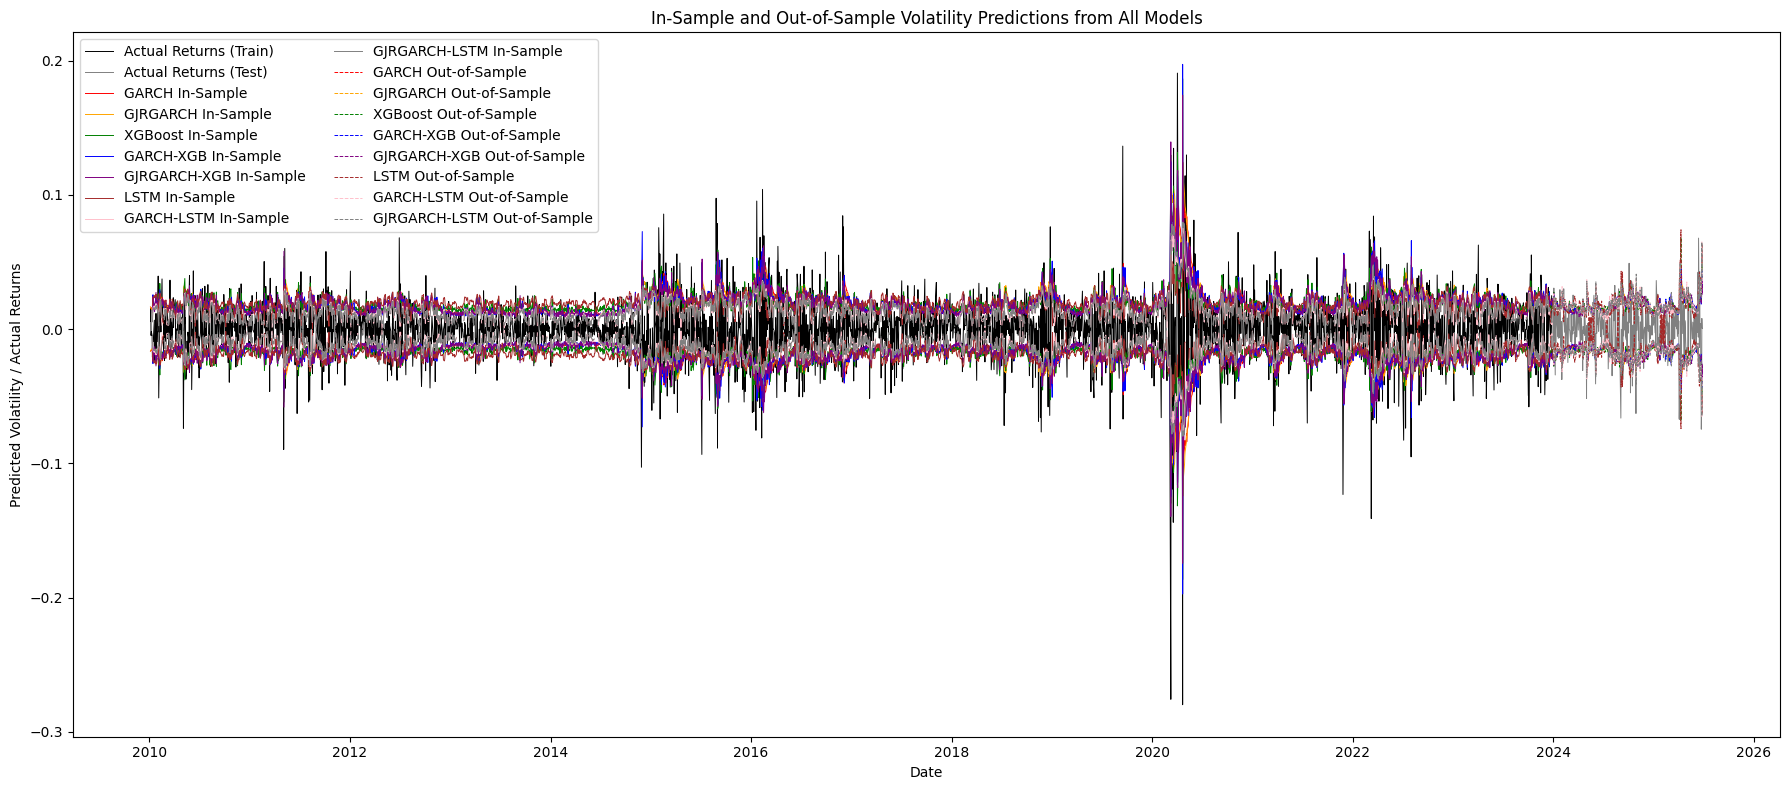

In [57]:
plt.figure(figsize=(18, 8))

# Actual returns (train)
plt.plot(df_all['train_returns'].index.to_timestamp(), df_all['train_returns'], label='Actual Returns (Train)', color='black', linewidth=0.7)

# Actual returns (test)
plt.plot(df_all['test_returns'].index.to_timestamp(), df_all['test_returns'], label='Actual Returns (Test)', color='gray', linewidth=0.7)

# In-sample volatility (solid lines)
plt.plot(df_all['GARCH_in_sample'].index.to_timestamp(), np.sqrt(df_all['GARCH_in_sample']), label='GARCH In-Sample', color='red', linestyle='-', linewidth=0.7)
plt.plot(df_all['GARCH_in_sample'].index.to_timestamp(), -np.sqrt(df_all['GARCH_in_sample']), color='red', linestyle='-', linewidth=0.7)

plt.plot(df_all['GJRGARCH_in_sample'].index.to_timestamp(), np.sqrt(df_all['GJRGARCH_in_sample']), label='GJRGARCH In-Sample', color='orange', linestyle='-', linewidth=0.7)
plt.plot(df_all['GJRGARCH_in_sample'].index.to_timestamp(), -np.sqrt(df_all['GJRGARCH_in_sample']), color='orange', linestyle='-', linewidth=0.7)

plt.plot(df_all['XGB_in_sample'].index.to_timestamp(), np.sqrt(df_all['XGB_in_sample']), label='XGBoost In-Sample', color='green', linestyle='-', linewidth=0.7)
plt.plot(df_all['XGB_in_sample'].index.to_timestamp(), -np.sqrt(df_all['XGB_in_sample']), color='green', linestyle='-', linewidth=0.7)

plt.plot(df_all['GARCH_XGB_in_sample'].index.to_timestamp(), np.sqrt(df_all['GARCH_XGB_in_sample']), label='GARCH-XGB In-Sample', color='blue', linestyle='-', linewidth=0.7)
plt.plot(df_all['GARCH_XGB_in_sample'].index.to_timestamp(), -np.sqrt(df_all['GARCH_XGB_in_sample']), color='blue', linestyle='-', linewidth=0.7)

plt.plot(df_all['GJRGARCH_XGB_in_sample'].index.to_timestamp(), np.sqrt(df_all['GJRGARCH_XGB_in_sample']), label='GJRGARCH-XGB In-Sample', color='purple', linestyle='-', linewidth=0.7)
plt.plot(df_all['GJRGARCH_XGB_in_sample'].index.to_timestamp(), -np.sqrt(df_all['GJRGARCH_XGB_in_sample']), color='purple', linestyle='-', linewidth=0.7)

plt.plot(df_all['LSTM_in_sample'].index.to_timestamp(), np.sqrt(df_all['LSTM_in_sample']), label='LSTM In-Sample', color='brown', linestyle='-', linewidth=0.7)
plt.plot(df_all['LSTM_in_sample'].index.to_timestamp(), -np.sqrt(df_all['LSTM_in_sample']), color='brown', linestyle='-', linewidth=0.7)

plt.plot(df_all['GARCH_LSTM_in_sample'].index.to_timestamp(), np.sqrt(df_all['GARCH_LSTM_in_sample']), label='GARCH-LSTM In-Sample', color='pink', linestyle='-', linewidth=0.7)
plt.plot(df_all['GARCH_LSTM_in_sample'].index.to_timestamp(), -np.sqrt(df_all['GARCH_LSTM_in_sample']), color='pink', linestyle='-', linewidth=0.7)

plt.plot(df_all['GJRGARCH_LSTM_in_sample'].index.to_timestamp(), np.sqrt(df_all['GJRGARCH_LSTM_in_sample']), label='GJRGARCH-LSTM In-Sample', color='gray', linestyle='-', linewidth=0.7)
plt.plot(df_all['GJRGARCH_LSTM_in_sample'].index.to_timestamp(), -np.sqrt(df_all['GJRGARCH_LSTM_in_sample']), color='gray', linestyle='-', linewidth=0.7)

# Out-of-sample volatility (dashed lines)
plt.plot(df_all['GARCH_out_of_sample'].index.to_timestamp(), np.sqrt(df_all['GARCH_out_of_sample']), label='GARCH Out-of-Sample', color='red', linestyle='--', linewidth=0.7)
plt.plot(df_all['GARCH_out_of_sample'].index.to_timestamp(), -np.sqrt(df_all['GARCH_out_of_sample']), color='red', linestyle='--', linewidth=0.7)

plt.plot(df_all['GJRGARCH_out_of_sample'].index.to_timestamp(), np.sqrt(df_all['GJRGARCH_out_of_sample']), label='GJRGARCH Out-of-Sample', color='orange', linestyle='--', linewidth=0.7)
plt.plot(df_all['GJRGARCH_out_of_sample'].index.to_timestamp(), -np.sqrt(df_all['GJRGARCH_out_of_sample']), color='orange', linestyle='--', linewidth=0.7)

plt.plot(df_all['XGB_out_of_sample'].index.to_timestamp(), np.sqrt(df_all['XGB_out_of_sample']), label='XGBoost Out-of-Sample', color='green', linestyle='--', linewidth=0.7)
plt.plot(df_all['XGB_out_of_sample'].index.to_timestamp(), -np.sqrt(df_all['XGB_out_of_sample']), color='green', linestyle='--', linewidth=0.7)

plt.plot(df_all['GARCH_XGB_out_of_sample'].index.to_timestamp(), np.sqrt(df_all['GARCH_XGB_out_of_sample']), label='GARCH-XGB Out-of-Sample', color='blue', linestyle='--', linewidth=0.7)
plt.plot(df_all['GARCH_XGB_out_of_sample'].index.to_timestamp(), -np.sqrt(df_all['GARCH_XGB_out_of_sample']), color='blue', linestyle='--', linewidth=0.7)

plt.plot(df_all['GJRGARCH_XGB_out_of_sample'].index.to_timestamp(), np.sqrt(df_all['GJRGARCH_XGB_out_of_sample']), label='GJRGARCH-XGB Out-of-Sample', color='purple', linestyle='--', linewidth=0.7)
plt.plot(df_all['GJRGARCH_XGB_out_of_sample'].index.to_timestamp(), -np.sqrt(df_all['GJRGARCH_XGB_out_of_sample']), color='purple', linestyle='--', linewidth=0.7)

plt.plot(df_all['LSTM_out_of_sample'].index.to_timestamp(), np.sqrt(df_all['LSTM_out_of_sample']), label='LSTM Out-of-Sample', color='brown', linestyle='--', linewidth=0.7)
plt.plot(df_all['LSTM_out_of_sample'].index.to_timestamp(), -np.sqrt(df_all['LSTM_out_of_sample']), color='brown', linestyle='--', linewidth=0.7)

plt.plot(df_all['GARCH_LSTM_out_of_sample'].index.to_timestamp(), np.sqrt(df_all['GARCH_LSTM_out_of_sample']), label='GARCH-LSTM Out-of-Sample', color='pink', linestyle='--', linewidth=0.7)
plt.plot(df_all['GARCH_LSTM_out_of_sample'].index.to_timestamp(), -np.sqrt(df_all['GARCH_LSTM_out_of_sample']), color='pink', linestyle='--', linewidth=0.7)

plt.plot(df_all['GJRGARCH_LSTM_out_of_sample'].index.to_timestamp(), np.sqrt(df_all['GJRGARCH_LSTM_out_of_sample']), label='GJRGARCH-LSTM Out-of-Sample', color='gray', linestyle='--', linewidth=0.7)
plt.plot(df_all['GJRGARCH_LSTM_out_of_sample'].index.to_timestamp(), -np.sqrt(df_all['GJRGARCH_LSTM_out_of_sample']), color='gray', linestyle='--', linewidth=0.7)

plt.title('In-Sample and Out-of-Sample Volatility Predictions from All Models')
plt.xlabel('Date')
plt.ylabel('Predicted Volatility / Actual Returns')
plt.legend(loc='upper left', ncol=2)
plt.tight_layout()
plt.show()

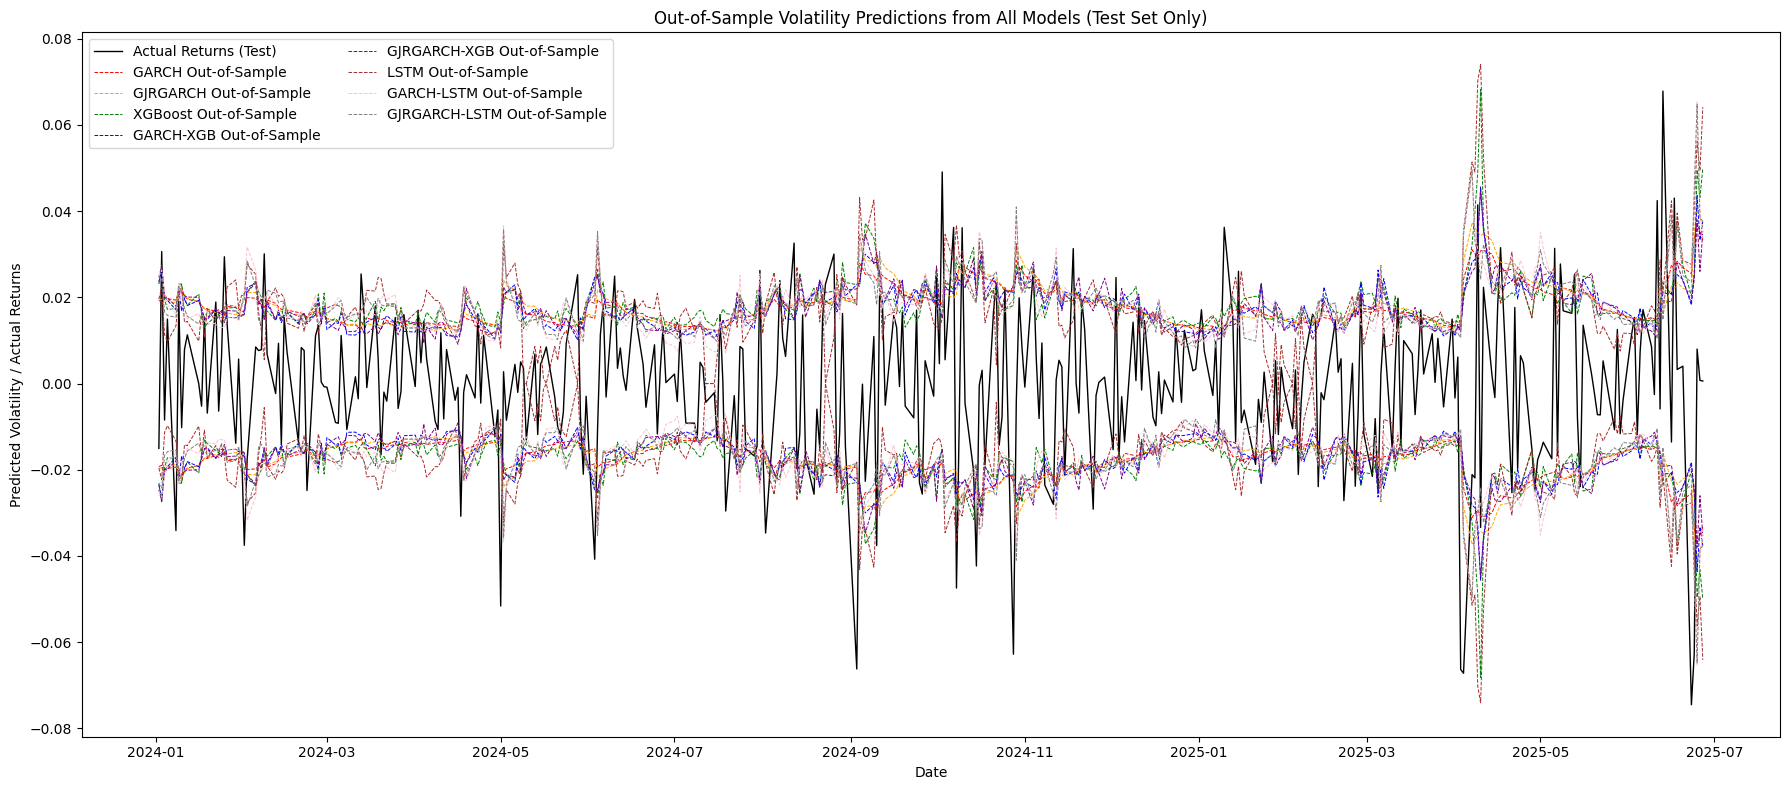

In [58]:
plt.figure(figsize=(18, 8))

# Actual returns (test)
plt.plot(df_all['test_returns'].index.to_timestamp(), df_all['test_returns'], label='Actual Returns (Test)', color='black', linewidth=1)

# Out-of-sample volatility predictions (dashed lines)
plt.plot(df_all['GARCH_out_of_sample'].index.to_timestamp(), np.sqrt(df_all['GARCH_out_of_sample']), label='GARCH Out-of-Sample', color='red', linestyle='--', linewidth=0.7)
plt.plot(df_all['GARCH_out_of_sample'].index.to_timestamp(), -np.sqrt(df_all['GARCH_out_of_sample']), color='red', linestyle='--', linewidth=0.7)

plt.plot(df_all['GJRGARCH_out_of_sample'].index.to_timestamp(), np.sqrt(df_all['GJRGARCH_out_of_sample']), label='GJRGARCH Out-of-Sample', color='orange', linestyle='--', linewidth=0.7)
plt.plot(df_all['GJRGARCH_out_of_sample'].index.to_timestamp(), -np.sqrt(df_all['GJRGARCH_out_of_sample']), color='orange', linestyle='--', linewidth=0.7)

plt.plot(df_all['XGB_out_of_sample'].index.to_timestamp(), np.sqrt(df_all['XGB_out_of_sample']), label='XGBoost Out-of-Sample', color='green', linestyle='--', linewidth=0.7)
plt.plot(df_all['XGB_out_of_sample'].index.to_timestamp(), -np.sqrt(df_all['XGB_out_of_sample']), color='green', linestyle='--', linewidth=0.7)

plt.plot(df_all['GARCH_XGB_out_of_sample'].index.to_timestamp(), np.sqrt(df_all['GARCH_XGB_out_of_sample']), label='GARCH-XGB Out-of-Sample', color='blue', linestyle='--', linewidth=0.7)
plt.plot(df_all['GARCH_XGB_out_of_sample'].index.to_timestamp(), -np.sqrt(df_all['GARCH_XGB_out_of_sample']), color='blue', linestyle='--', linewidth=0.7)

plt.plot(df_all['GJRGARCH_XGB_out_of_sample'].index.to_timestamp(), np.sqrt(df_all['GJRGARCH_XGB_out_of_sample']), label='GJRGARCH-XGB Out-of-Sample', color='purple', linestyle='--', linewidth=0.7)
plt.plot(df_all['GJRGARCH_XGB_out_of_sample'].index.to_timestamp(), -np.sqrt(df_all['GJRGARCH_XGB_out_of_sample']), color='purple', linestyle='--', linewidth=0.7)

plt.plot(df_all['LSTM_out_of_sample'].index.to_timestamp(), np.sqrt(df_all['LSTM_out_of_sample']), label='LSTM Out-of-Sample', color='brown', linestyle='--', linewidth=0.7)
plt.plot(df_all['LSTM_out_of_sample'].index.to_timestamp(), -np.sqrt(df_all['LSTM_out_of_sample']), color='brown', linestyle='--', linewidth=0.7)

plt.plot(df_all['GARCH_LSTM_out_of_sample'].index.to_timestamp(), np.sqrt(df_all['GARCH_LSTM_out_of_sample']), label='GARCH-LSTM Out-of-Sample', color='pink', linestyle='--', linewidth=0.7)
plt.plot(df_all['GARCH_LSTM_out_of_sample'].index.to_timestamp(), -np.sqrt(df_all['GARCH_LSTM_out_of_sample']), color='pink', linestyle='--', linewidth=0.7)

plt.plot(df_all['GJRGARCH_LSTM_out_of_sample'].index.to_timestamp(), np.sqrt(df_all['GJRGARCH_LSTM_out_of_sample']), label='GJRGARCH-LSTM Out-of-Sample', color='gray', linestyle='--', linewidth=0.7)
plt.plot(df_all['GJRGARCH_LSTM_out_of_sample'].index.to_timestamp(), -np.sqrt(df_all['GJRGARCH_LSTM_out_of_sample']), color='gray', linestyle='--', linewidth=0.7)

plt.title('Out-of-Sample Volatility Predictions from All Models (Test Set Only)')
plt.xlabel('Date')
plt.ylabel('Predicted Volatility / Actual Returns')
plt.legend(loc='upper left', ncol=2)
plt.tight_layout()
plt.show()

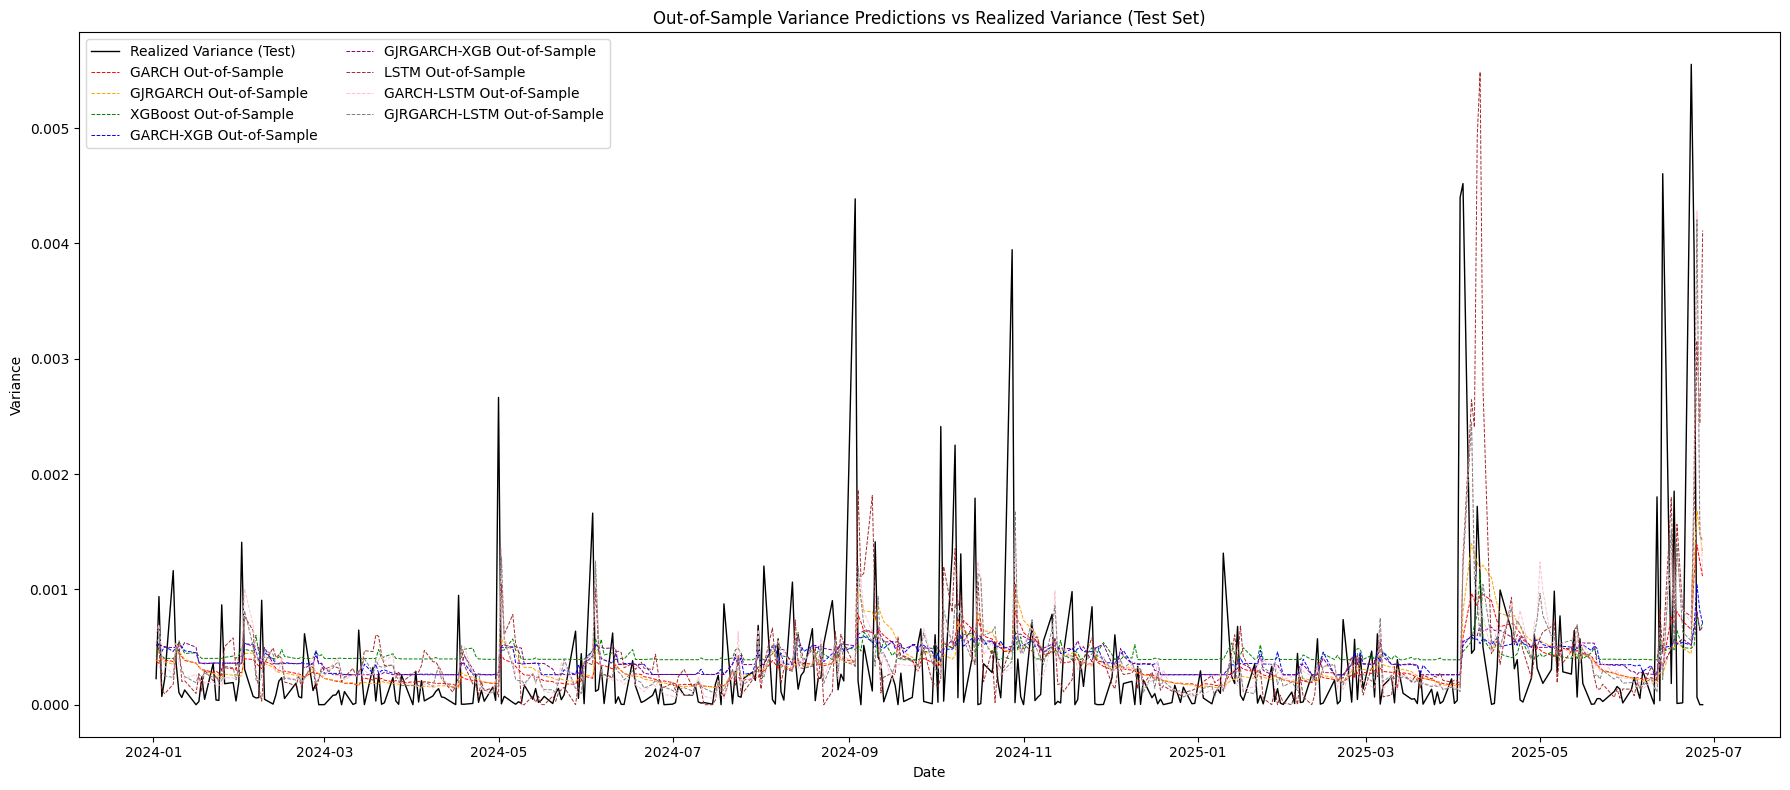

In [42]:
plt.figure(figsize=(18, 8))

# Squared returns (realized variance, test set)
plt.plot(test_returns.index.to_timestamp(), test_returns ** 2, label='Realized Variance (Test)', color='black', linewidth=1)

# Out-of-sample variance predictions
plt.plot(conditional_variance_out_of_sample_GARCH.index.to_timestamp(), conditional_variance_out_of_sample_GARCH, label='GARCH Out-of-Sample', color='red', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_GJRGARCH.index.to_timestamp(), conditional_variance_out_of_sample_GJRGARCH, label='GJRGARCH Out-of-Sample', color='orange', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_XGB.index.to_timestamp(), conditional_variance_out_of_sample_XGB, label='XGBoost Out-of-Sample', color='green', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_GARCH_XGB.index.to_timestamp(), conditional_variance_out_of_sample_GARCH_XGB, label='GARCH-XGB Out-of-Sample', color='blue', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_GJRGARCH_XGB.index.to_timestamp(), conditional_variance_out_of_sample_GJRGARCH_XGB, label='GJRGARCH-XGB Out-of-Sample', color='purple', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_LSTM.index.to_timestamp(), conditional_variance_out_of_sample_LSTM, label='LSTM Out-of-Sample', color='brown', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_GARCH_LSTM.index.to_timestamp(), conditional_variance_out_of_sample_GARCH_LSTM, label='GARCH-LSTM Out-of-Sample', color='pink', linestyle='--', linewidth=0.7)
plt.plot(conditional_variance_out_of_sample_GJRGARCH_LSTM.index.to_timestamp(), conditional_variance_out_of_sample_GJRGARCH_LSTM, label='GJRGARCH-LSTM Out-of-Sample', color='gray', linestyle='--', linewidth=0.7)

plt.title('Out-of-Sample Variance Predictions vs Realized Variance (Test Set)')
plt.xlabel('Date')
plt.ylabel('Variance')
plt.legend(loc='upper left', ncol=2)
plt.tight_layout()
plt.show()